 # Of Bikes and Cabs

I recently uploaded a dataset about bike rides in NYC covering the same period of time of the taxi dataset (the dataset comes from public available bike sharing data provived by Citi Bike about their service). 
It is formatted in a way that should make straightforward to apply on it any method developed for the taxi data.
Here I start exploring some of the most obvious features hoping to expand soon. 
Some interesting questions are about correlation between the two datasets:
- are the distributions of trip durations over the day similar?
- are taxi and bike rides, and their durations, similarly influenced by weather or traffic?
- can I use bike rides to make any prediction on cabs?

**We will discover that bikes can be faster**

There are also fun questions, for instance when it's faster to ride a bike, or if there was any major event that can be found by examining large deviations between the two sets.

**This is my first online kernel, all comments and questions are appreciated. Room for improvement is endless**


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")

Upload data

In [2]:
taxi_df = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv')
bike_df = pd.read_csv('../input/new-york-citi-bike-trip-duration/citi_bike_2016.csv')

For a scatter plot map I take a random sample from the taxi dataset, while I select the complete set of Citi Bike stations checking that the number is consistent with online data (~500 stations).

In [3]:
bike_stations = bike_df[['pickup_longitude','pickup_latitude']].drop_duplicates()
len(bike_stations)

492

Now I can plot the points. In orange the taxi pickups, in blue the bike stations.
It is immediate to see that bike stations, and thus bike rides, have a good coverage of Manhattan, especially below Central Park, and parts of Brooklyn.



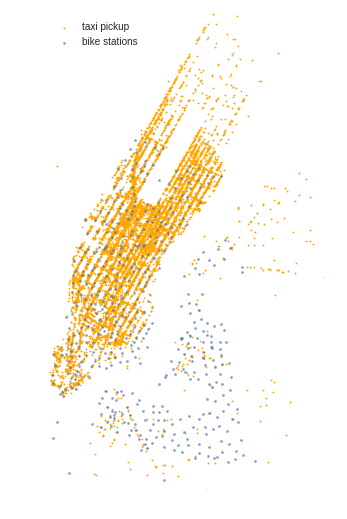

In [4]:
plt.figure(figsize=(5,5*1.75))
plt.scatter(taxi_df['pickup_longitude'][:10000],taxi_df['pickup_latitude'][:10000],s=2,color='orange', label='taxi pickup')
plt.scatter(bike_stations['pickup_longitude'],bike_stations['pickup_latitude'],s=5,alpha=0.7,label='bike stations')
plt.axis([-74.02,-73.90,40.67,40.83])
plt.legend()
plt.axis('off')
plt.show()

Remove outliers and resctrict the dataset in a simple way. For instance I exclude trips to airports and trips that are either too long or too short..  

In [5]:
long_lim = [-74.02,-73.90]
lat_lim  = [40.67,40.83]
taxi_dur_lim  = [np.percentile(taxi_df['trip_duration'], 0.5), np.percentile(taxi_df['trip_duration'], 99.5)]
bike_dur_lim  = [np.percentile(bike_df['trip_duration'], 0.5), np.percentile(bike_df['trip_duration'], 99.5)]


taxi_df = taxi_df[(taxi_df['pickup_latitude'].between(lat_lim[0],lat_lim[1])) & (taxi_df['pickup_longitude'].between(long_lim[0],long_lim[1]))]
taxi_df = taxi_df[(taxi_df['dropoff_latitude'].between(lat_lim[0],lat_lim[1])) & (taxi_df['dropoff_longitude'].between(long_lim[0],long_lim[1]))]

taxi_df= taxi_df[taxi_df['trip_duration'].between(taxi_dur_lim[0],taxi_dur_lim[1])]

bike_df= bike_df[bike_df['trip_duration'].between(bike_dur_lim[0],bike_dur_lim[1])]

taxi_df = taxi_df.reset_index(drop=True)

bike_df = bike_df.reset_index(drop=True)

In [6]:
taxi_df['dist_lat']   = 111.2 * 1000  * (taxi_df['dropoff_latitude']-taxi_df['pickup_latitude'])
taxi_df['dist_long']   = 84.3 * 1000  * (taxi_df['dropoff_longitude']-taxi_df['pickup_longitude'])

bike_df['dist_lat']   = 111.2 * 1000  * (bike_df['dropoff_latitude']-bike_df['pickup_latitude'])
bike_df['dist_long']   = 84.3 * 1000  * ( bike_df['dropoff_longitude']-bike_df['pickup_longitude'])

I assign to each trip an L1 distance, having in mind the grid structure of Manhattan (and beyond) and expecting that it will be closer to the real one than the simple L2 distance (for completeness and later use I compute also it)

At this point we can also define an average velocity for each trip, and get rid of outliers

In [7]:
w=np.array([0.874804, 0.484478]) #unit vector along the Aveneus direction, pointing towards NNE 
def L1_dist(x):
    v=np.array([x['dist_lat'] ,x['dist_long']])
    va = w* np.dot(v,w)
    vb= v-va
    return np.sqrt(va.dot(va))+np.sqrt(vb.dot(vb))

In [8]:
taxi_df['L1_dist'] = taxi_df.apply(L1_dist, axis=1)
bike_df['L1_dist'] = bike_df.apply(L1_dist, axis=1)

taxi_df['L2_dist']   = np.sqrt(taxi_df['dist_lat']**2+taxi_df['dist_long']**2)
bike_df['L2_dist']   = np.sqrt(bike_df['dist_lat']**2+bike_df['dist_long']**2)

In [9]:
taxi_df['vel'] = taxi_df['L1_dist']/taxi_df['trip_duration']
bike_df['vel'] = bike_df['L1_dist']/bike_df['trip_duration']


taxi_vel_lim  = [np.percentile(taxi_df['vel'], 0.5), np.percentile(taxi_df['vel'], 99.9)]
bike_vel_lim  = [np.percentile(bike_df['vel'], 0.5), np.percentile(bike_df['vel'], 99.9)]


taxi_df= taxi_df[(taxi_df['vel'].between(taxi_vel_lim[0],taxi_vel_lim[1]))& taxi_df['L1_dist']>0]

bike_df= bike_df[(bike_df['vel'].between(bike_vel_lim[0],bike_vel_lim[1]))& bike_df['L1_dist']>0]

Other fields that will be useful later

In [10]:
taxi_df['weekday'] = pd.to_datetime(taxi_df['pickup_datetime']).dt.weekday
bike_df['weekday'] = pd.to_datetime(bike_df['pickup_datetime']).dt.weekday

taxi_df['hour'] = pd.to_datetime(taxi_df['pickup_datetime']).dt.hour
bike_df['hour'] = pd.to_datetime(bike_df['pickup_datetime']).dt.hour

taxi_df['dayyear'] =  pd.to_datetime(taxi_df['pickup_datetime']).dt.dayofyear
bike_df['dayyear'] =  pd.to_datetime(bike_df['pickup_datetime']).dt.dayofyear

taxi_df['weekhour'] = taxi_df['weekday']*24 + taxi_df['hour']
bike_df['weekhour'] = bike_df['weekday']*24 + bike_df['hour']

wh_list=sorted(taxi_df['weekhour'].unique())

len_taxi=len(taxi_df)
len_bike=len(bike_df)

# What is faster?

We will discover that taxis are not always the faster option.

Let's start with a few plots that show how taxis are usually faster than bikes, but cover comparable distances

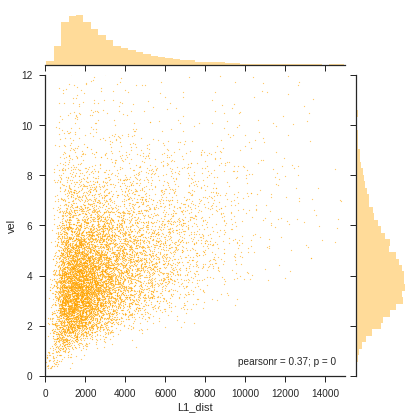

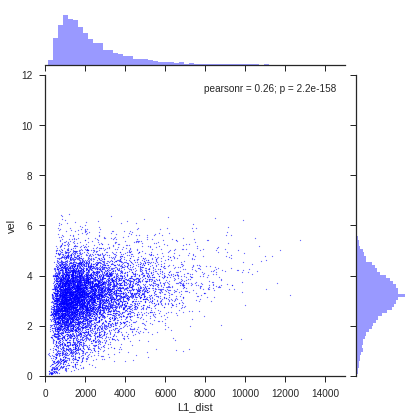

In [11]:
sns.jointplot(taxi_df['L1_dist'][:10000],taxi_df['vel'][:10000],s=1,alpha=0.5,color='orange',xlim=(0,15000), ylim=(0,12))
sns.jointplot(bike_df['L1_dist'][:10000],bike_df['vel'][:10000],s=1,alpha=0.5,color='blue',xlim=(0,15000), ylim=(0,12))

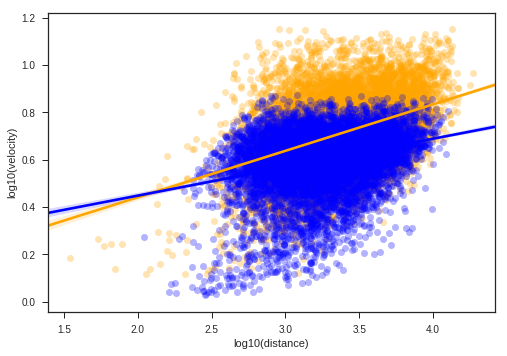

In [12]:
fig, ax = plt.subplots()
sns.regplot(np.log10(taxi_df['L1_dist'][:10000]),np.log10(taxi_df['vel'][:10000]+1),color='orange', ax=ax ,scatter_kws={'alpha':0.3})
sns.regplot(np.log10(bike_df['L1_dist'][:10000]),np.log10(bike_df['vel'][:10000]+1),color='blue', ax=ax,scatter_kws={'alpha':0.3})
ax.set_xlabel('log10(distance)');ax.set_ylabel('log10(velocity)');## Trip Velocity



Summing over all week and splitting a week in 24x7 one hour time windows, here we compute the average trip duration for every trip starting within each of such windows.

In [13]:
taxi_vel_m = []
bike_vel_m = []
taxi_vel_u = []
bike_vel_u = []
taxi_vel_d = []
bike_vel_d = []
for x in range(len(wh_list)):
    taxi_vel_m.append( (taxi_df[taxi_df['weekhour']==x]['vel'].median()))
    bike_vel_m.append( (bike_df[bike_df['weekhour']==x]['vel'].median()))
    taxi_vel_u.append( np.percentile(taxi_df[taxi_df['weekhour']==x]['vel'],50+34.1))
    bike_vel_u.append( np.percentile(bike_df[bike_df['weekhour']==x]['vel'],50+34.1))
    taxi_vel_d.append( np.percentile(taxi_df[taxi_df['weekhour']==x]['vel'],50-34.1))
    bike_vel_d.append( np.percentile(bike_df[bike_df['weekhour']==x]['vel'],50-34.1))

Plotting the result we start seeing both some correlation and some difference during the weekends. 
During weekdays bikes can be faster than taxis, when the traffic slows them down the most. No match at night.

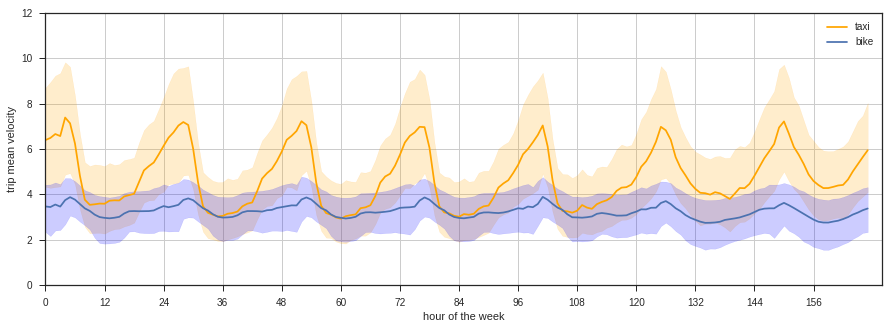

In [14]:
plt.figure(figsize=(15,5))
plt.plot(wh_list, taxi_vel_m ,color='orange',label='taxi')
plt.fill_between(wh_list, taxi_vel_d, taxi_vel_u, color='orange',alpha=0.2)
plt.plot(wh_list,bike_vel_m, label='bike')
plt.fill_between(wh_list, bike_vel_d, bike_vel_u, color='blue',alpha=.2)
plt.xlabel('hour of the week')
plt.ylabel('trip mean velocity')
plt.axis([0,170,0,12])
plt.xticks(range(0,168,12))
plt.legend()
plt.grid()
plt.show()

As expected bikes have the same average velocity throughout the day, why the peak around 2-3am? Maybe bikers do not care about traffic lights when it is so late? Are they running away from something?

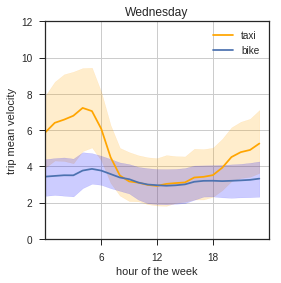

In [15]:
fig = plt.figure(1,figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(np.array(wh_list[48:72])-48, taxi_vel_m[48:72] ,color='orange',label='taxi')
ax.fill_between(np.array(wh_list[48:72])-48, taxi_vel_d[48:72], taxi_vel_u[48:72], color='orange',alpha=0.2)
ax.plot(np.array(wh_list[48:72])-48,bike_vel_m[48:72], label='bike')
ax.fill_between(np.array(wh_list[48:72])-48, bike_vel_d[48:72], bike_vel_u[48:72], color='blue',alpha=.2)
ax.set_xlabel('hour of the week');ax.set_ylabel('trip mean velocity')
ax.axis([0,24,0,12])
ax.set_xticks([6, 12, 18])
ax.title.set_text('Wednesday')
plt.legend()
ax.grid()

Here I try to visualize when during the year the median velocity of bikers is higher then that of cabs

In [16]:
taxi_matrix=taxi_df.groupby(['dayyear','hour'])['vel'].median().reset_index().pivot("hour","dayyear", "vel")
bike_matrix=bike_df.groupby(['dayyear','hour'])['vel'].median().reset_index().pivot("hour","dayyear", "vel")

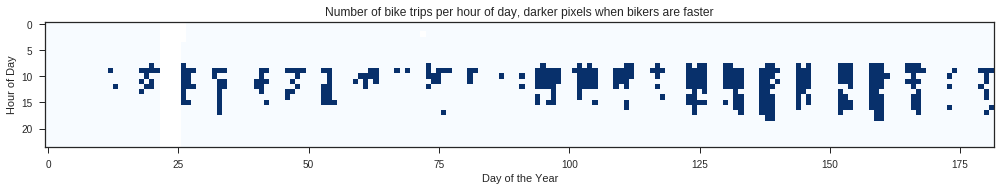

In [17]:
plt.figure(figsize=(17,10))
plt.imshow(np.sign(bike_matrix-taxi_matrix)+1.01,cmap=cm.Blues)
plt.title('Number of bike trips per hour of day, darker pixels when bikers are faster')
plt.xlabel('Day of the Year')
plt.ylabel('Hour of Day')

It corresponds to what we saw earlier, during weekdays and not at night. Better/warmer weather helps too.

Now I want to briefly explore the duration dependence on the time of the day and on the day of the week.

## Usage

Let us briefly explore the usage of taxi and bikes per hour of the week. We stack all weeks in the dataset and compute the number of bikes and taxi trips that start within one hour window (normalized to the total number for sake of visualization).

In [18]:
taxi_wh_use = []
bike_wh_use = []
for x in range(len(wh_list)):
    taxi_wh_use.append(len(taxi_df[taxi_df['weekhour']==x])*1.0/len_taxi)
    bike_wh_use.append(len(bike_df[bike_df['weekhour']==x])*1.0/len_bike)

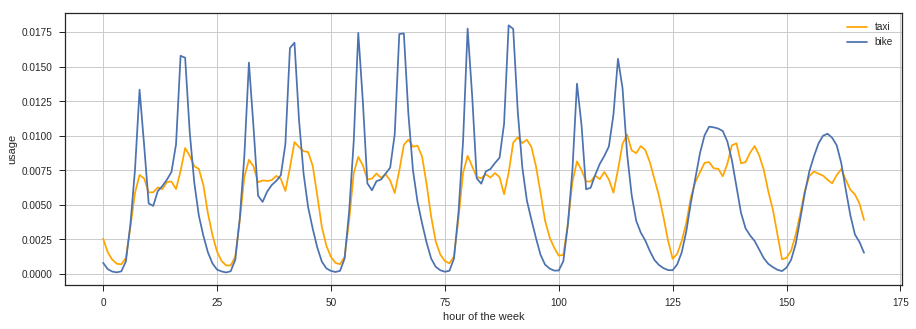

In [19]:
plt.figure(figsize=(15,5))
plt.plot(wh_list, taxi_wh_use ,color='orange',label='taxi')
plt.plot(wh_list,bike_wh_use, label='bike')
plt.xlabel('hour of the week')
plt.ylabel('usage')
plt.grid()
plt.legend()
plt.show()

Interestingly people use both taxi and bikes more when coming back from work than when going to work. It also seems like they use bikes earlier in the evening. Cabs might present two evening peaks (before and after dinner?)

Now we can take a look at the entire semester, with no stacking. 

In [20]:
taxi_df['dayyear'] =  pd.to_datetime(taxi_df['pickup_datetime']).dt.dayofyear
bike_df['dayyear'] =  pd.to_datetime(bike_df['pickup_datetime']).dt.dayofyear

In [21]:
taxi_matrix=taxi_df.groupby(['dayyear','hour'])['id'].count().reset_index().pivot("hour","dayyear", "id")/len_taxi
bike_matrix=bike_df.groupby(['dayyear','hour'])['id'].count().reset_index().pivot("hour","dayyear", "id")/len_bike

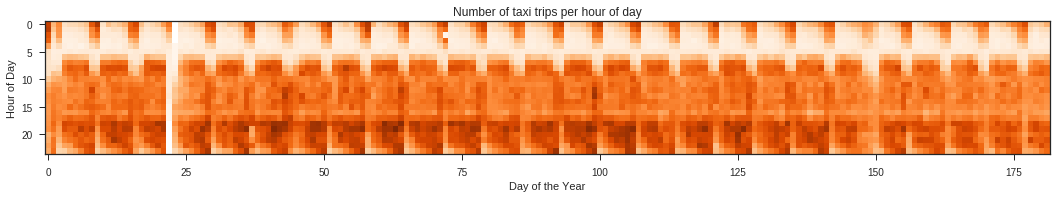

In [22]:
plt.figure(figsize=(18,10)) 
plt.title('Number of taxi trips per hour of day')
plt.imshow(taxi_matrix,cmap=cm.Oranges) 
plt.xlabel('Day of the Year')
plt.ylabel('Hour of Day')

Both datasets show some interruption due to the snow storm in late January. 

Cabs have weekend night peak that is not visibile for bikes.
Bike also clearly present a steady increase during the year, as the weather gets warmer and better.
Maybe it is possible to find major weather events in the bike data...?

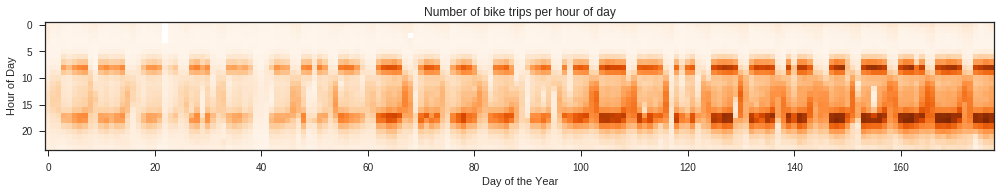

In [23]:
plt.figure(figsize=(17,10))
plt.imshow(bike_matrix,cmap=cm.Oranges)
plt.title('Number of bike trips per hour of day')
plt.xlabel('Day of the Year')
plt.ylabel('Hour of Day')

## Trip Duration

Summing over all week and splitting a week in 24x7 one hour time windows, here we compute the average trip duration for every trip starting within each of such windows.

In [24]:
taxi_wh_mean = []
bike_wh_mean = []
for x in range(len(wh_list)):
    taxi_wh_mean.append( (taxi_df[taxi_df['weekhour']==x]['trip_duration'].mean()))
    bike_wh_mean.append( (bike_df[bike_df['weekhour']==x]['trip_duration'].mean()))

Plotting the result we start seeing both some correlation and some difference during the weekends. 

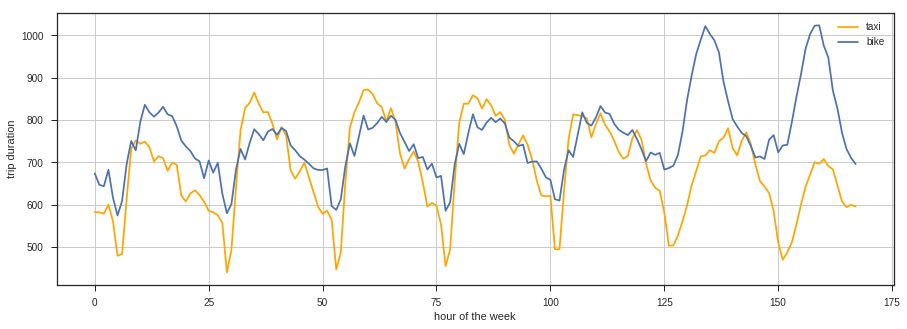

In [25]:
plt.figure(figsize=(15,5))
plt.plot(wh_list, taxi_wh_mean ,color='orange',label='taxi')
plt.plot(wh_list,bike_wh_mean, label='bike')
plt.xlabel('hour of the week')
plt.ylabel('trip duration')
plt.legend()
plt.grid()
plt.show()

To better visualize the results I redo the above day by day and I normalize on the average duration on that day.

In [26]:
taxi_daily_mean = []
bike_daily_mean = []
for x in range(7):
    taxi_daily_mean.append( taxi_df[taxi_df['weekday'] ==x]['trip_duration'].mean())
    bike_daily_mean.append( bike_df[bike_df['weekday']==x]['trip_duration'].mean())

Weekdays present a very interesting correlation

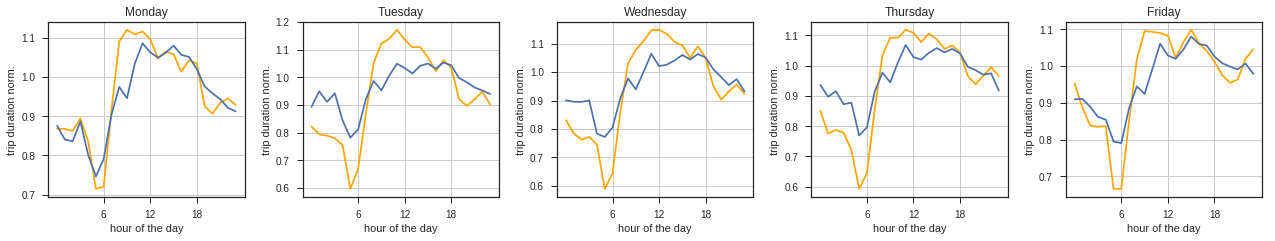

In [27]:
days_names=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig, axArray = plt.subplots(nrows=1,ncols=5,figsize=(18,3.5))
plt.tight_layout(pad=2)
for i_wd in range(5):
    axArray[i_wd].plot(range(24),taxi_wh_mean[24*i_wd :24*(i_wd+1)]/ taxi_daily_mean[i_wd],color='orange')
    axArray[i_wd].plot(range(24),bike_wh_mean[24*i_wd :24*(i_wd+1)]/bike_daily_mean[i_wd])
    axArray[i_wd].set_xlabel('hour of the day')
    axArray[i_wd].set_ylabel('trip duration norm.')
    axArray[i_wd].grid()
    axArray[i_wd].set_xticks([6, 12, 18])
    axArray[i_wd].title.set_text(days_names[i_wd])

Saturday and Sunday are not as easily interpretable as weekdays. Looking at the week plot we can see that many people take much longer bike rides during the weekend, most probably for fun. 
Nobody rides cabs for fun. 
Goodbye correlation!

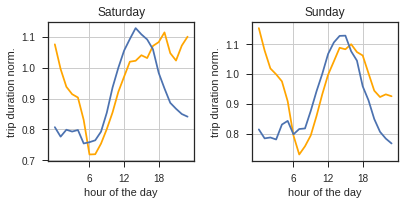

In [28]:
fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(6,3))
plt.tight_layout(pad=2)
for i_wd in [5,6]:
    axArray[i_wd-5].plot(range(24),taxi_wh_mean[24*i_wd :24*(i_wd+1)]/taxi_daily_mean[i_wd],color='orange')
    axArray[i_wd-5].plot(range(24),bike_wh_mean[24*i_wd :24*(i_wd+1)]/bike_daily_mean[i_wd])
    axArray[i_wd-5].set_xlabel('hour of the day')
    axArray[i_wd-5].set_ylabel('trip duration norm.')
    axArray[i_wd-5].grid()
    axArray[i_wd-5].set_xticks([6, 12, 18])
    axArray[i_wd-5].title.set_text(days_names[i_wd])

## Destinations

Trying some visualization idea.
I assign a unit vector pointing in the destination direction for each trip. Then all unit vectors in a small spatial region are added, then I visualize the result which should show a sort of flow map.
[the normalization is arbitrary]

In [29]:
def arrow(df, min_lat, max_lat, min_long, max_long):
    x1= (min_long+max_long)/2
    x2= (min_lat+max_lat)/2
    
    red_df = df[(df['pickup_latitude'].between(min_lat,max_lat)) & (df['pickup_longitude'].between(min_long,max_long))]
    if len(red_df)>0:
        red_df['v1'] = red_df['dist_long']/red_df['L2_dist']
        red_df['v2'] = red_df['dist_lat']/red_df['L2_dist']
        v1=red_df['v1'].sum()/1000
        v2=red_df['v2'].sum()/1000
        return [x1,x2,v1,v2]

For now I try only 7 to 8am

In [30]:
nn=20
d_lat=0.08/nn
d_long=0.1/nn

hhour = 7

v_list_tx=[]
v_list_bk=[]

for i_lat in range(nn):
    for i_long in range(nn):
        v_list_tx.append(arrow(taxi_df[taxi_df['hour']==hhour][:10000],40.7+d_long*i_long,40.7+d_long*(1+i_long),-74.02+d_lat*i_lat,-74.02+d_lat*(1+i_lat)))
        v_list_bk.append(arrow(bike_df[bike_df['hour']==hhour][:10000],40.7+d_long*i_long,40.7+d_long*(1+i_long),-74.02+d_lat*i_lat,-74.02+d_lat*(1+i_lat)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
varray_tx = filter(None,np.array(v_list_tx))
varray_bk = filter(None,np.array(v_list_bk))
Xtx, Ytx, V1tx, V2tx = zip(*varray_tx)
Xbk, Ybk, V1bk, V2bk = zip(*varray_bk)

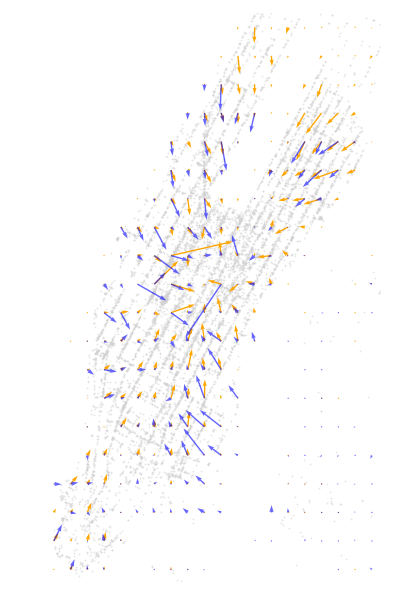

In [32]:
plt.figure()
plt.figure(figsize=(6,6*1.75))

ax = plt.gca()
ax.scatter(taxi_df['pickup_longitude'][:10000],taxi_df['pickup_latitude'][:10000],s=2,color='lightgray',alpha=0.5, label='taxi pickup')
ax.quiver(Xtx, Ytx, V1tx, V2tx, angles='xy', scale_units='xy', scale=16.,color='orange')
ax.quiver(Xbk, Ybk, V1bk, V2bk, angles='xy', scale_units='xy', scale=16.,color='blue',alpha=0.6)
ax.set_xlim([-74.02,-73.94])
ax.set_ylim([40.7,40.8])
plt.axis('off')
#ax.axis([-74.02,-73.94,40.7,40.8])
plt.draw()
plt.show()

Midtown is a taxi black hole. Large flux from Penn Station (?) 
East Villagers love bikes, or at least they all go in the same direction.